In [78]:
import pandas as pd 
import time
import requests
import json

API_KEY = "295202-66cdaf"
AIRPORT_IATA = "SLC"
DATE_FROM = "2024-05-10"
DATE_TO = "2024-06-01"

In [79]:
def get_flight_data(airport_iata, date_from, date_to, api_key):
    url = f"https://aviation-edge.com/v2/public/flightsHistory?key={api_key}&code={airport_iata}&type=departure&date_from={date_from}&date_to={date_to}"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None


In [80]:
def process_flight_data(flight_data):
    flight_list = []

    for flight in flight_data:
        try:
            flight_list.append({
                "Flight Number": flight.get("flight", {}).get("iataNumber", "N/A"),
                "Airline": flight.get("airline", {}).get("name", "N/A"),
                "Departure Airport": flight.get("departure", {}).get("iataCode", "N/A"),
                "Scheduled Departure": flight.get("departure", {}).get("scheduledTime", "N/A"),
                "Actual Departure": flight.get("departure", {}).get("actualTime", "N/A"),
                "Status": flight.get("status", "N/A"),
                "Delay (minutes)": flight.get("departure", {}).get("delay", "N/A")
            })
        except Exception as e:
            print(f"Error processing flight: {e}")

    return pd.DataFrame(flight_list)



In [81]:
df = get_flight_data(AIRPORT_IATA, DATE_FROM, DATE_TO, API_KEY)
df = pd.DataFrame(df) 


In [82]:
departure_data = df['departure']

# Convert departure column data into a DataFrame (if it's in dictionary format)
departure_df = pd.DataFrame(departure_data.tolist())

# Extract relevant columns
departure_df_result = departure_df[['delay', 'scheduledTime', 'actualTime']]

# Convert time columns to datetime format
departure_df_result['scheduledTime'] = pd.to_datetime(departure_df_result['scheduledTime'], format='%Y-%m-%dT%H:%M:%S.%f')
departure_df_result['actualTime'] = pd.to_datetime(departure_df_result['actualTime'], format='%Y-%m-%dT%H:%M:%S.%f')

# Extract date and day of the week from 'scheduledTime'
departure_df_result['date'] = departure_df_result['scheduledTime'].dt.date
departure_df_result['Day of the week'] = departure_df_result['scheduledTime'].dt.day_name()

# Display the final DataFrame with the extracted columns
print(departure_df_result)

       delay       scheduledTime          actualTime        date  \
0       26.0 2024-05-09 18:00:00 2024-05-09 18:26:00  2024-05-09   
1       13.0 2024-05-09 18:20:00 2024-05-09 18:32:00  2024-05-09   
2       75.0 2024-05-09 18:30:00                 NaT  2024-05-09   
3       75.0 2024-05-09 18:30:00                 NaT  2024-05-09   
4       75.0 2024-05-09 18:30:00                 NaT  2024-05-09   
...      ...                 ...                 ...         ...   
21606    NaN 2024-06-01 12:50:00 2024-06-01 12:50:00  2024-06-01   
21607    NaN 2024-06-01 17:00:00                 NaT  2024-06-01   
21608    NaN 2024-06-01 16:30:00 2024-06-01 16:26:00  2024-06-01   
21609   10.0 2024-06-01 17:08:00                 NaT  2024-06-01   
21610   14.0 2024-06-01 17:18:00                 NaT  2024-06-01   

      Day of the week  
0            Thursday  
1            Thursday  
2            Thursday  
3            Thursday  
4            Thursday  
...               ...  
21606        Sa

C:\Users\User\AppData\Local\Temp\ipykernel_2884\750878279.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  departure_df_result['scheduledTime'] = pd.to_datetime(departure_df_result['scheduledTime'], format='%Y-%m-%dT%H:%M:%S.%f')
C:\Users\User\AppData\Local\Temp\ipykernel_2884\750878279.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  departure_df_result['actualTime'] = pd.to_datetime(departure_df_result['actualTime'], format='%Y-%m-%dT%H:%M:%S.%f')
C:\Users\User\AppData\Local\Temp\ipykernel_2884\75

In [83]:
airline_data = df['airline']

airline_df = pd.DataFrame(airline_data.tolist())
airline_df_result = airline_df[['name']]
airline_df_result.columns = ['airline']
df['airline'] = airline_df_result['airline']

In [84]:
df[['delay', 'scheduledTime', 'actualTime', 'date', 'Day of the week']] = departure_df_result
df[['airline']] = airline_df_result

df = df.drop(columns = ['codeshared', 'flight', 'status', 'departure', 'arrival'])
df = df[df['airline'].isin(['delta air lines', 'american airlines', 'southwest airlines', 'jetblue airways', 'frontier airlines', 'alaska airlines', 'aeromexico', 'spirit airlines', 'hawaiian airlines', 'united airlines'])]

In [86]:
df = pd.DataFrame(df) 
df.to_csv("flights_data.csv")


This next section is going to be the part for some of my analysis. 

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("flights_data.csv")

# Group by airline and calculate the mean delay
avg_delay_by_airline = df.groupby("airline")["delay"].mean().sort_values(ascending=False)

# Display the results
print(avg_delay_by_airline)


airline
hawaiian airlines     42.157895
frontier airlines     38.258883
american airlines     32.145889
united airlines       28.032110
jetblue airways       27.477612
spirit airlines       26.362319
southwest airlines    24.925676
aeromexico            23.128589
delta air lines       22.011465
alaska airlines       21.730000
Name: delay, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_2884\3493529515.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_delay_by_airline.index, y=avg_delay_by_airline.values, palette="magma")


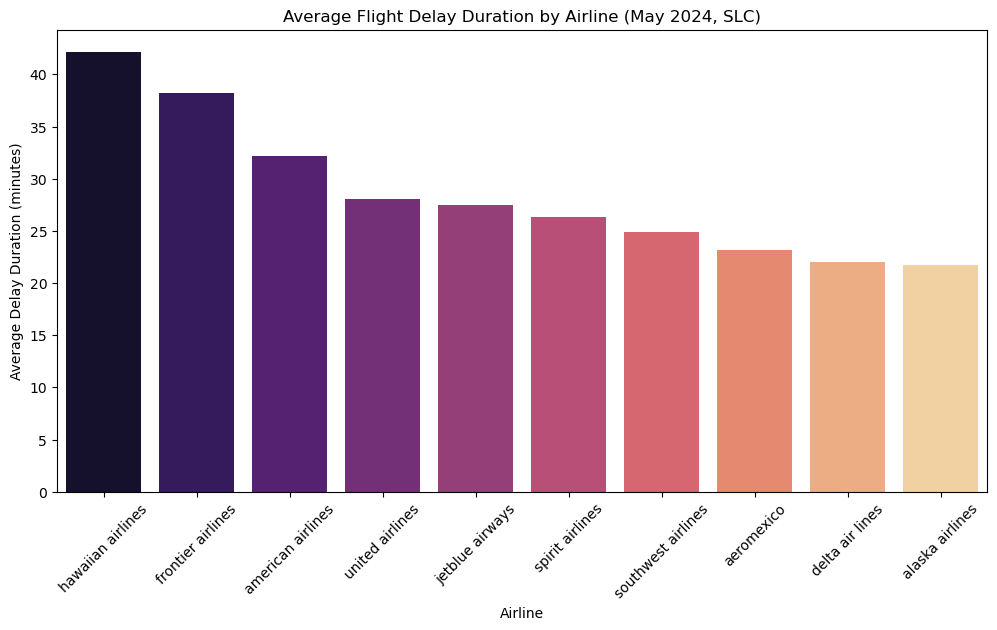

In [93]:
# Plot bar graph
plt.figure(figsize=(12,6))
sns.barplot(x=avg_delay_by_airline.index, y=avg_delay_by_airline.values, palette="magma")

# Add labels and title
plt.title("Average Flight Delay Duration by Airline (May 2024, SLC)")
plt.xlabel("Airline")
plt.ylabel("Average Delay Duration (minutes)")
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [90]:
# Count total flights per airline
total_flights = df["airline"].value_counts()

# Count flights delayed by 10+ minutes per airline
delayed_25min_flights = df[df["delay"] >= 25]["airline"].value_counts()

# Calculate the percentage
delay_25min_percentage = (delayed_25min_flights / total_flights) * 100

# Fill missing values with 0 (for airlines with no 10+ min delays)
delay_25min_percentage = delay_25min_percentage.fillna(0).sort_values(ascending=False)

# Display the results
print(delay_25min_percentage)



airline
hawaiian airlines     56.097561
frontier airlines     39.320388
jetblue airways       35.616438
united airlines       31.707317
american airlines     29.620253
spirit airlines       28.767123
southwest airlines    27.526596
aeromexico            26.097133
alaska airlines       24.299065
delta air lines       22.865796
Name: count, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_2884\2053683085.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


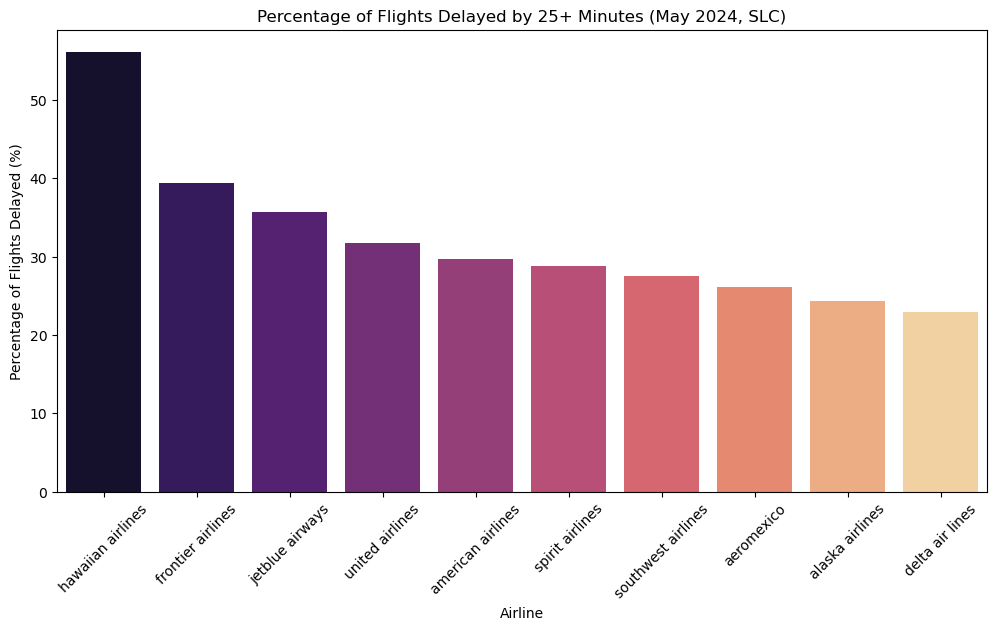

In [95]:
color_mapping = {
    "hawaiian airlines": "#1f77b4",  # Blue
    "frontier airlines": "#ff7f0e",  # Orange
    "jetblue airways": "#2ca02c",    # Green
    "american airlines": "#d62728",  # Red
    "aeromexico": "#9467bd",         # Purple
    "southwest airlines": "#8c564b", # Brown
    "spirit airlines": "#e377c2",    # Pink
    "delta air lines": "#7f7f7f",    # Gray
    "alaska airlines": "#bcbd22",    # Yellow-Green
    "united airlines": "#17becf"     # Cyan
}

plt.figure(figsize=(12,6))
sns.barplot(
    x=delay_25min_percentage.index,
    y=delay_25min_percentage.values,
    palette="magma"
)

plt.title("Percentage of Flights Delayed by 25+ Minutes (May 2024, SLC)")
plt.xlabel("Airline")
plt.ylabel("Percentage of Flights Delayed (%)")
plt.xticks(rotation=45)

plt.show()

